In [101]:
import os
import re
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm

try:
    from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
    import nltk
    nltk.download('punkt', quiet=True)
    BLEU_AVAILABLE = True
except ImportError:
    print("NLTK not installed. Run: pip install nltk")
    BLEU_AVAILABLE = False

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


In [102]:
# Model Architecture
EMBED_DIM = 256
HIDDEN_DIM = 512
ATTENTION_DIM = 256
ENCODER_DIM = 2048
DROPOUT = 0.2

# Training
BATCH_SIZE = 64
NUM_EPOCHS = 25
LEARNING_RATE = 3e-4
ENCODER_LR = 1e-4
FINE_TUNE_ENCODER = True
FINE_TUNE_AFTER = 5

# Vocabulary
MIN_WORD_FREQ = 5
MAX_CAPTION_LEN = 50

# Data Split (Flickr8k standard)
TRAIN_SIZE = 6000
VAL_SIZE = 1000
TEST_SIZE = 1000

# Paths
DATA_DIR = './caption_data'
IMAGES_DIR = './caption_data/Images'
CAPTIONS_FILE = './caption_data/captions.txt'
CHECKPOINT_DIR = './checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)


## Part 2: Vocabulary Building

In [103]:
def clean_caption(text):
    """Clean caption: lowercase, remove punctuation/numbers/single chars."""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = [w for w in text.split() if len(w) > 1 or w in ['a', 'i']]
    return ' '.join(words).strip()


class Vocabulary:
    """Word-to-index mappings with special tokens: PAD, SOS, EOS, UNK."""
    
    def __init__(self, min_freq=5):
        self.min_freq = min_freq
        self.word2idx = {}
        self.idx2word = {}
        self.word_freq = Counter()
        self.PAD_TOKEN = '<PAD>'
        self.SOS_TOKEN = '<SOS>'
        self.EOS_TOKEN = '<EOS>'
        self.UNK_TOKEN = '<UNK>'
        self._init_special_tokens()
    
    def _init_special_tokens(self):
        for idx, token in enumerate([self.PAD_TOKEN, self.SOS_TOKEN, self.EOS_TOKEN, self.UNK_TOKEN]):
            self.word2idx[token] = idx
            self.idx2word[idx] = token
    
    def build_vocabulary(self, captions):
        for caption in tqdm(captions, desc="Building vocab"):
            self.word_freq.update(caption.split())
        
        idx = len(self.word2idx)
        for word, freq in self.word_freq.items():
            if freq >= self.min_freq and word not in self.word2idx:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1
        
        print(f"Vocabulary: {len(self.word2idx)} words (filtered {sum(1 for f in self.word_freq.values() if f < self.min_freq)} rare words)")
    
    def encode(self, caption):
        caption = clean_caption(caption)
        indices = [self.word2idx[self.SOS_TOKEN]]
        for token in caption.split():
            indices.append(self.word2idx.get(token, self.word2idx[self.UNK_TOKEN]))
        indices.append(self.word2idx[self.EOS_TOKEN])
        return indices
    
    def decode(self, indices):
        words = []
        for idx in indices:
            if isinstance(idx, torch.Tensor):
                idx = idx.item()
            word = self.idx2word.get(idx, self.UNK_TOKEN)
            if word == self.EOS_TOKEN:
                break
            if word not in [self.PAD_TOKEN, self.SOS_TOKEN]:
                words.append(word)
        return ' '.join(words)
    
    def __len__(self):
        return len(self.word2idx)
    
    def save(self, path):
        data = {'word2idx': self.word2idx, 'idx2word': {int(k): v for k, v in self.idx2word.items()}, 
                'min_freq': self.min_freq, 'word_freq': dict(self.word_freq)}
        with open(path, 'w') as f:
            json.dump(data, f)
    
    @classmethod
    def load(cls, path):
        with open(path, 'r') as f:
            data = json.load(f)
        vocab = cls(min_freq=data['min_freq'])
        vocab.word2idx = data['word2idx']
        vocab.idx2word = {int(k): v for k, v in data['idx2word'].items()}
        if 'word_freq' in data:
            vocab.word_freq = Counter(data['word_freq'])
        return vocab

## Part 3: Data Loading

In [104]:
def load_captions(captions_file):
    """Load and clean captions from file."""
    image_captions = {}
    
    with open(captions_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    start_idx = 1 if 'image' in lines[0].lower() and 'caption' in lines[0].lower() else 0
    
    for line in lines[start_idx:]:
        line = line.strip()
        if not line:
            continue
        
        parts = line.split(',', 1) if ',' in line else line.split('\t', 1)
        if len(parts) != 2:
            continue
        
        image_name, caption = parts[0].strip(), parts[1].strip()
        if '#' in image_name:
            image_name = image_name.split('#')[0]
        
        cleaned = clean_caption(caption)
        if cleaned:
            if image_name not in image_captions:
                image_captions[image_name] = []
            image_captions[image_name].append(cleaned)
    
    print(f"Loaded {len(image_captions)} images, {sum(len(c) for c in image_captions.values())} captions")
    return image_captions


def create_data_splits(image_captions, train_size=6000, val_size=1000, test_size=1000, seed=42):
    """Split data into train/val/test sets."""
    image_names = list(image_captions.keys())
    np.random.seed(seed)
    np.random.shuffle(image_names)
    
    n_total = len(image_names)
    if n_total < train_size + val_size + test_size:
        ratio = n_total / (train_size + val_size + test_size)
        train_size, val_size = int(train_size * ratio), int(val_size * ratio)
        test_size = n_total - train_size - val_size
    
    train_captions = {img: image_captions[img] for img in image_names[:train_size]}
    val_captions = {img: image_captions[img] for img in image_names[train_size:train_size + val_size]}
    test_captions = {img: image_captions[img] for img in image_names[train_size + val_size:train_size + val_size + test_size]}
    
    print(f"Split: {len(train_captions)} train, {len(val_captions)} val, {len(test_captions)} test")
    return train_captions, val_captions, test_captions

In [105]:
class CaptionDataset(Dataset):
    """Dataset for image-caption pairs."""
    
    def __init__(self, image_captions, images_dir, vocab, transform=None, max_len=50):
        self.images_dir = images_dir
        self.vocab = vocab
        self.transform = transform
        self.max_len = max_len
        self.samples = [(img, cap) for img, caps in image_captions.items() for cap in caps]
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_name, caption = self.samples[idx]
        image = Image.open(os.path.join(self.images_dir, img_name)).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        encoded = self.vocab.encode(caption)
        if len(encoded) > self.max_len:
            encoded = encoded[:self.max_len-1] + [self.vocab.word2idx[self.vocab.EOS_TOKEN]]
        
        return image, torch.tensor(encoded, dtype=torch.long)


def collate_fn(batch):
    """Pad captions to same length within batch."""
    images, captions = zip(*batch)
    images = torch.stack(images, dim=0)
    lengths = torch.tensor([len(c) for c in captions], dtype=torch.long)
    captions = pad_sequence(captions, batch_first=True, padding_value=0)
    return images, captions, lengths

In [106]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [107]:
def create_data_splits(image_captions, train_ratio=0.8, val_ratio=0.1):
    """
    Split data into train/val/test sets.
    
    Args:
        image_captions: dict of {image_name: [captions]}
        train_ratio: Proportion for training
        val_ratio: Proportion for validation
    
    Returns:
        train_captions, val_captions, test_captions (dicts)
    """
    image_names = list(image_captions.keys())
    np.random.seed(42)  # For reproducibility
    np.random.shuffle(image_names)
    
    n_total = len(image_names)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    
    train_images = image_names[:n_train]
    val_images = image_names[n_train:n_train + n_val]
    test_images = image_names[n_train + n_val:]
    
    train_captions = {img: image_captions[img] for img in train_images}
    val_captions = {img: image_captions[img] for img in val_images}
    test_captions = {img: image_captions[img] for img in test_images}
    
    print(f"Train: {len(train_captions)} images")
    print(f"Val: {len(val_captions)} images")
    print(f"Test: {len(test_captions)} images")
    
    return train_captions, val_captions, test_captions

## Load Data and Build Vocabulary

**Note:** Update the paths below after extracting your dataset.

In [108]:
# ============================================
# LOAD DATA AND BUILD VOCABULARY
# ============================================

# Check if data directory exists
if not os.path.exists(CAPTIONS_FILE):
    print(f"WARNING: Captions file not found at {CAPTIONS_FILE}")
    print("Please extract your caption_data.zip and update the paths above.")
    print("\nExpected structure:")
    print("  caption_data/")
    print("  ├── images/")
    print("  │   ├── image1.jpg")
    print("  │   ├── image2.jpg")
    print("  │   └── ...")
    print("  └── captions.txt")
else:
    # Load and clean captions
    image_captions = load_captions(CAPTIONS_FILE)
    
    # Create train/val/test splits (Standard Flickr8k: 6000/1000/1000)
    train_captions, val_captions, test_captions = create_data_splits(
        image_captions,
        0.75,

    )
    
    # Build vocabulary from training data only (prevents data leakage)
    all_train_captions = [cap for caps in train_captions.values() for cap in caps]
    vocab = Vocabulary(min_freq=MIN_WORD_FREQ)
    vocab.build_vocabulary(all_train_captions)
    
    # Save vocabulary
    vocab.save(os.path.join(CHECKPOINT_DIR, 'vocab.json'))

Loaded 8091 images, 40455 captions
Train: 6068 images
Val: 809 images
Test: 1214 images


Building vocab: 100%|██████████| 30340/30340 [00:00<00:00, 472417.80it/s]

Vocabulary: 2569 words (filtered 5129 rare words)


DATA EXPLORATION


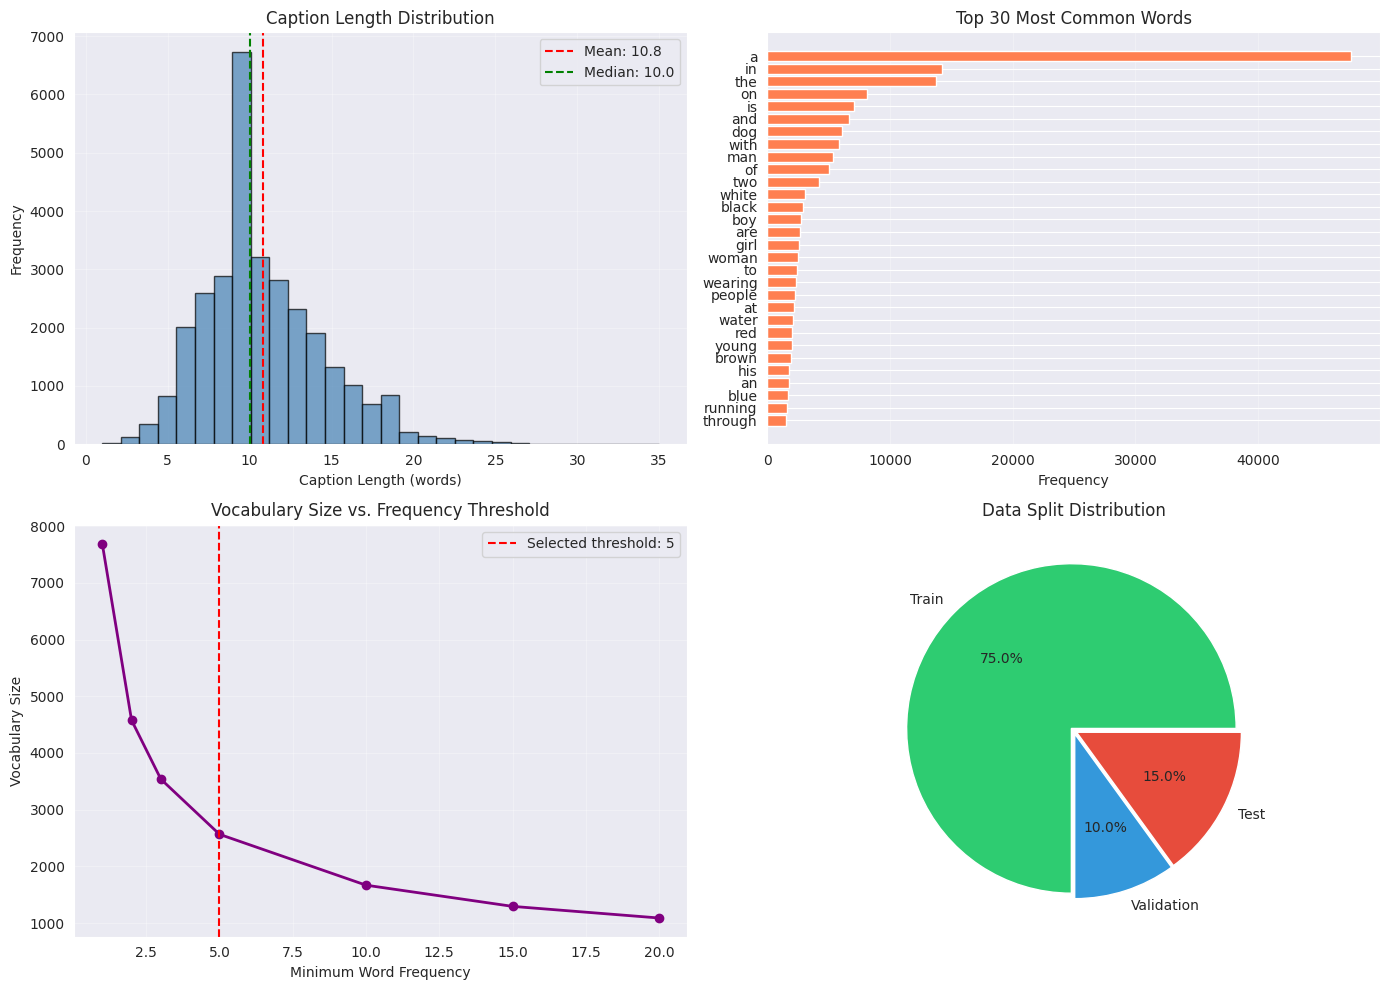


Caption Length Statistics:
  Min: 1 words
  Max: 35 words
  Mean: 10.8 words
  Median: 10.0 words
  Std: 3.7 words

  Recommended MAX_CAPTION_LEN: 22 (99th percentile)


In [109]:
# ============================================
# DATA EXPLORATION AND VISUALIZATION
# ============================================

if os.path.exists(CAPTIONS_FILE):
    print("="*60)
    print("DATA EXPLORATION")
    print("="*60)
    
    # Caption length analysis
    caption_lengths = [len(cap.split()) for cap in all_train_captions]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Caption Length Distribution
    axes[0, 0].hist(caption_lengths, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 0].axvline(np.mean(caption_lengths), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(caption_lengths):.1f}')
    axes[0, 0].axvline(np.median(caption_lengths), color='green', linestyle='--',
                       label=f'Median: {np.median(caption_lengths):.1f}')
    axes[0, 0].set_xlabel('Caption Length (words)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Caption Length Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Word Frequency Distribution (Top 30)
    top_words = vocab.word_freq.most_common(30)
    words, freqs = zip(*top_words)
    axes[0, 1].barh(range(len(words)), freqs, color='coral')
    axes[0, 1].set_yticks(range(len(words)))
    axes[0, 1].set_yticklabels(words)
    axes[0, 1].invert_yaxis()
    axes[0, 1].set_xlabel('Frequency')
    axes[0, 1].set_title('Top 30 Most Common Words')
    axes[0, 1].grid(True, alpha=0.3, axis='x')
    
    # 3. Vocabulary Coverage by Frequency Threshold
    thresholds = [1, 2, 3, 5, 10, 15, 20]
    vocab_sizes = []
    for thresh in thresholds:
        size = sum(1 for freq in vocab.word_freq.values() if freq >= thresh)
        vocab_sizes.append(size)
    
    axes[1, 0].plot(thresholds, vocab_sizes, marker='o', linewidth=2, color='purple')
    axes[1, 0].axvline(MIN_WORD_FREQ, color='red', linestyle='--', 
                       label=f'Selected threshold: {MIN_WORD_FREQ}')
    axes[1, 0].set_xlabel('Minimum Word Frequency')
    axes[1, 0].set_ylabel('Vocabulary Size')
    axes[1, 0].set_title('Vocabulary Size vs. Frequency Threshold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Data Split Visualization
    split_names = ['Train', 'Validation', 'Test']
    split_sizes = [len(train_captions), len(val_captions), len(test_captions)]
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    
    axes[1, 1].pie(split_sizes, labels=split_names, autopct='%1.1f%%', 
                   colors=colors, explode=(0.02, 0.02, 0.02))
    axes[1, 1].set_title('Data Split Distribution')
    
    plt.tight_layout()
    plt.savefig(os.path.join(CHECKPOINT_DIR, 'data_exploration.png'), dpi=150)
    plt.show()
    
    # Print statistics
    print(f"\nCaption Length Statistics:")
    print(f"  Min: {min(caption_lengths)} words")
    print(f"  Max: {max(caption_lengths)} words")
    print(f"  Mean: {np.mean(caption_lengths):.1f} words")
    print(f"  Median: {np.median(caption_lengths):.1f} words")
    print(f"  Std: {np.std(caption_lengths):.1f} words")
    print(f"\n  Recommended MAX_CAPTION_LEN: {int(np.percentile(caption_lengths, 99))} (99th percentile)")

In [110]:
# ============================================
# CREATE DATASETS AND DATALOADERS
# ============================================

if os.path.exists(CAPTIONS_FILE):
    # Create datasets
    train_dataset = CaptionDataset(
        train_captions, IMAGES_DIR, vocab, 
        transform=train_transform, max_len=MAX_CAPTION_LEN
    )
    
    val_dataset = CaptionDataset(
        val_captions, IMAGES_DIR, vocab,
        transform=val_transform, max_len=MAX_CAPTION_LEN
    )
    
    test_dataset = CaptionDataset(
        test_captions, IMAGES_DIR, vocab,
        transform=val_transform, max_len=MAX_CAPTION_LEN
    )
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        collate_fn=collate_fn, num_workers=0, pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        collate_fn=collate_fn, num_workers=0, pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False,
        collate_fn=collate_fn, num_workers=0, pin_memory=True
    )
    
    print(f"\nDataloaders created:")
    print(f"  Train batches: {len(train_loader)}")
    print(f"  Val batches: {len(val_loader)}")
    print(f"  Test batches: {len(test_loader)}")


Dataloaders created:
  Train batches: 475
  Val batches: 64
  Test batches: 95


In [111]:
# Visualize a sample batch
if os.path.exists(CAPTIONS_FILE):
    images, captions, lengths = next(iter(train_loader))
    
    print(f"Batch shapes:")
    print(f"  Images: {images.shape}")
    print(f"  Captions: {captions.shape}")
    print(f"  Lengths: {lengths.shape}")
    
    # Decode first caption
    print(f"\nSample caption (encoded): {captions[0][:lengths[0]].tolist()}")
    print(f"Sample caption (decoded): {vocab.decode(captions[0].tolist())}")

Batch shapes:
  Images: torch.Size([64, 3, 224, 224])
  Captions: torch.Size([64, 20])
  Lengths: torch.Size([64])

Sample caption (encoded): [1, 4, 43, 210, 249, 15, 4, 2232, 71, 40, 901, 2]
Sample caption (decoded): a man stands outside of a doorway on his cellphone


---
## End of Part 1: Data Loading

**Next:** Part 2 - CNN Encoder (ResNet-50)

In [112]:
class EncoderCNN(nn.Module):
    """ResNet-50 encoder for image features."""
    
    def __init__(self, encoded_image_size=7, fine_tune=False):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        self.set_fine_tuning(fine_tune)
    
    def set_fine_tuning(self, fine_tune):
        for param in self.resnet.parameters():
            param.requires_grad = False
        if fine_tune:
            for layer in list(self.resnet.children())[6:]:
                for param in layer.parameters():
                    param.requires_grad = True
    
    def forward(self, images):
        features = self.resnet(images)
        features = self.adaptive_pool(features)
        batch_size, encoder_dim = features.size(0), features.size(1)
        return features.view(batch_size, encoder_dim, -1).permute(0, 2, 1)

In [113]:
# Test encoder
encoder_test = EncoderCNN(fine_tune=False).to(device)
dummy = torch.randn(2, 3, 224, 224).to(device)
out = encoder_test(dummy)
print(f"Encoder: {dummy.shape} -> {out.shape}")
del encoder_test, dummy, out
torch.cuda.empty_cache() if torch.cuda.is_available() else None

Encoder: torch.Size([2, 3, 224, 224]) -> torch.Size([2, 49, 2048])


In [114]:
# Test the encoder
print("Testing EncoderCNN...")
encoder_test = EncoderCNN(fine_tune=False).to(device)

# Create dummy input
dummy_images = torch.randn(2, 3, 224, 224).to(device)
features = encoder_test(dummy_images)

print(f"Input shape: {dummy_images.shape}")
print(f"Output shape: {features.shape}")
print(f"Expected: (2, 49, 2048)")

# Count parameters
total_params = sum(p.numel() for p in encoder_test.parameters())
trainable_params = sum(p.numel() for p in encoder_test.parameters() if p.requires_grad)
print(f"\nEncoder parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

del encoder_test, dummy_images, features
torch.cuda.empty_cache() if torch.cuda.is_available() else None

Testing EncoderCNN...
Input shape: torch.Size([2, 3, 224, 224])
Output shape: torch.Size([2, 49, 2048])
Expected: (2, 49, 2048)

Encoder parameters: 23,508,032
Trainable parameters: 0


In [115]:
class Attention(nn.Module):
    """Soft attention mechanism."""
    
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(att)
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return context, alpha

In [116]:
class DecoderLSTM(nn.Module):
    """LSTM decoder with attention."""
    
    def __init__(self, embed_dim, decoder_dim, attention_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        super(DecoderLSTM, self).__init__()
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.lstm_cell = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)
        
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
    
    def init_hidden_state(self, encoder_out):
        mean = encoder_out.mean(dim=1)
        return self.init_h(mean), self.init_c(mean)
    
    def forward(self, encoder_out, captions, caption_lengths):
        batch_size = encoder_out.size(0)
        num_pixels = encoder_out.size(1)
        
        caption_lengths, sort_idx = caption_lengths.sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_idx]
        captions = captions[sort_idx]
        
        embeddings = self.embedding(captions)
        h, c = self.init_hidden_state(encoder_out)
        
        decode_lengths = (caption_lengths - 1).tolist()
        max_len = max(decode_lengths)
        
        predictions = torch.zeros(batch_size, max_len, self.vocab_size).to(encoder_out.device)
        alphas = torch.zeros(batch_size, max_len, num_pixels).to(encoder_out.device)
        
        for t in range(max_len):
            batch_t = sum([l > t for l in decode_lengths])
            context, alpha = self.attention(encoder_out[:batch_t], h[:batch_t])
            gate = self.sigmoid(self.f_beta(h[:batch_t]))
            context = gate * context
            
            h_new, c_new = self.lstm_cell(
                torch.cat([embeddings[:batch_t, t], context], dim=1),
                (h[:batch_t], c[:batch_t])
            )
            
            h, c = h.clone(), c.clone()
            h[:batch_t], c[:batch_t] = h_new, c_new
            
            predictions[:batch_t, t] = self.fc(self.dropout(h_new))
            alphas[:batch_t, t] = alpha
        
        return predictions, alphas, captions, decode_lengths, sort_idx
    
    def generate(self, encoder_out, vocab, max_len=50, beam_size=1):
        if beam_size == 1:
            return self._greedy_decode(encoder_out, vocab, max_len)
        return self._beam_search(encoder_out, vocab, max_len, beam_size)
    
    def _greedy_decode(self, encoder_out, vocab, max_len):
        device = encoder_out.device
        h, c = self.init_hidden_state(encoder_out)
        word_idx = vocab.word2idx[vocab.SOS_TOKEN]
        caption, attention_weights = [], []
        
        for _ in range(max_len):
            emb = self.embedding(torch.tensor([word_idx]).to(device))
            context, alpha = self.attention(encoder_out, h)
            attention_weights.append(alpha.squeeze(0).cpu().detach().numpy())
            context = self.sigmoid(self.f_beta(h)) * context
            h, c = self.lstm_cell(torch.cat([emb, context], dim=1), (h, c))
            word_idx = self.fc(h).argmax(dim=1).item()
            
            if word_idx == vocab.word2idx[vocab.EOS_TOKEN]:
                break
            caption.append(vocab.idx2word[word_idx])
        
        return ' '.join(caption), attention_weights
    
    def _beam_search(self, encoder_out, vocab, max_len, beam_size):
        device = encoder_out.device
        num_pixels = encoder_out.size(1)
        encoder_out = encoder_out.expand(beam_size, num_pixels, self.encoder_dim)
        
        seqs = torch.tensor([[vocab.word2idx[vocab.SOS_TOKEN]]] * beam_size).to(device)
        scores = torch.zeros(beam_size, 1).to(device)
        h, c = self.init_hidden_state(encoder_out)
        
        complete_seqs, complete_scores = [], []
        
        for _ in range(max_len):
            emb = self.embedding(seqs[:, -1:]).squeeze(1)
            context, _ = self.attention(encoder_out, h)
            context = self.sigmoid(self.f_beta(h)) * context
            h, c = self.lstm_cell(torch.cat([emb, context], dim=1), (h, c))
            
            log_probs = torch.log_softmax(self.fc(h), dim=1)
            scores = scores.expand_as(log_probs) + log_probs
            
            if seqs.size(1) == 1:
                top_scores, top_words = scores[0].topk(beam_size)
            else:
                top_scores, top_words = scores.view(-1).topk(beam_size)
            
            prev_idx = top_words // self.vocab_size
            next_words = top_words % self.vocab_size
            seqs = torch.cat([seqs[prev_idx], next_words.unsqueeze(1)], dim=1)
            
            incomplete = [i for i, w in enumerate(next_words) if w != vocab.word2idx[vocab.EOS_TOKEN]]
            complete = [i for i, w in enumerate(next_words) if w == vocab.word2idx[vocab.EOS_TOKEN]]
            
            if complete:
                complete_seqs.extend(seqs[complete].tolist())
                complete_scores.extend(top_scores[complete].tolist())
            
            if not incomplete:
                break
            
            seqs = seqs[incomplete]
            h, c = h[prev_idx[incomplete]], c[prev_idx[incomplete]]
            encoder_out = encoder_out[prev_idx[incomplete]]
            scores = top_scores[incomplete].unsqueeze(1)
            beam_size = len(incomplete)
        
        if not complete_seqs:
            complete_seqs, complete_scores = seqs.tolist(), scores.squeeze(1).tolist()
        
        best = complete_seqs[complete_scores.index(max(complete_scores))]
        caption = [vocab.idx2word[i] for i in best[1:] 
                   if i not in [vocab.word2idx[vocab.SOS_TOKEN], vocab.word2idx[vocab.EOS_TOKEN], vocab.word2idx[vocab.PAD_TOKEN]]]
        return ' '.join(caption), []

In [117]:
class DecoderLSTM(nn.Module):
    """
    LSTM Decoder with Attention for image captioning.
    
    Generates captions word by word, attending to different
    parts of the encoded image at each timestep.
    """
    
    def __init__(self, embed_dim, decoder_dim, attention_dim, vocab_size, 
                 encoder_dim=2048, dropout=0.5):
        """
        Args:
            embed_dim: Dimension of word embeddings
            decoder_dim: Dimension of LSTM hidden state
            attention_dim: Dimension of attention network
            vocab_size: Size of vocabulary
            encoder_dim: Dimension of encoded image features
            dropout: Dropout probability
        """
        super(DecoderLSTM, self).__init__()
        
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.dropout = dropout
        
        # Attention network
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        
        # Word embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Dropout layer
        self.dropout_layer = nn.Dropout(dropout)
        
        # LSTM cell (not full LSTM - we need step-by-step control)
        # Input: concatenation of embedding and attention-weighted encoding
        self.lstm_cell = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim)
        
        # Linear layers to initialize LSTM states from encoder output
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        
        # Linear layer to create a sigmoid-activated gate
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        
        # Linear layer to find scores over vocabulary
        self.fc = nn.Linear(decoder_dim, vocab_size)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize some weights with uniform distribution."""
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)
    
    def init_hidden_state(self, encoder_out):
        """
        Initialize LSTM hidden state from encoder output.
        
        Args:
            encoder_out: (batch_size, num_pixels, encoder_dim)
        
        Returns:
            h: (batch_size, decoder_dim)
            c: (batch_size, decoder_dim)
        """
        # Mean of encoder output across spatial dimensions
        mean_encoder_out = encoder_out.mean(dim=1)  # (batch, encoder_dim)
        
        h = self.init_h(mean_encoder_out)  # (batch, decoder_dim)
        c = self.init_c(mean_encoder_out)  # (batch, decoder_dim)
        
        return h, c
    
    def forward(self, encoder_out, captions, caption_lengths):
        """
        Forward pass for training with teacher forcing.
        
        Args:
            encoder_out: (batch_size, num_pixels, encoder_dim)
            captions: (batch_size, max_caption_length)
            caption_lengths: (batch_size,)
        
        Returns:
            predictions: (batch_size, max_caption_length, vocab_size)
            alphas: (batch_size, max_caption_length, num_pixels)
        """
        batch_size = encoder_out.size(0)
        num_pixels = encoder_out.size(1)
        
        # Sort by decreasing caption length for efficient packing
        caption_lengths, sort_idx = caption_lengths.sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_idx]
        captions = captions[sort_idx]
        
        # Embed captions
        embeddings = self.embedding(captions)  # (batch, max_len, embed_dim)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)
        
        # We won't decode at <EOS> position, since we've finished when we hit <EOS>
        # So decode_length = caption_length - 1
        decode_lengths = (caption_lengths - 1).tolist()
        max_decode_length = max(decode_lengths)
        
        # Create tensors to hold predictions and attention weights
        predictions = torch.zeros(batch_size, max_decode_length, self.vocab_size).to(encoder_out.device)
        alphas = torch.zeros(batch_size, max_decode_length, num_pixels).to(encoder_out.device)
        
        # For each timestep
        for t in range(max_decode_length):
            # Determine batch size at this timestep (some sequences may have ended)
            batch_size_t = sum([l > t for l in decode_lengths])
            
            # Attention
            attention_weighted_encoding, alpha = self.attention(
                encoder_out[:batch_size_t], 
                h[:batch_size_t]
            )
            
            # Gating scalar (for doubly stochastic attention)
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            # LSTM input: concatenate embedding and attention-weighted encoding
            lstm_input = torch.cat([
                embeddings[:batch_size_t, t, :], 
                attention_weighted_encoding
            ], dim=1)
            
            # LSTM step
            h_new, c_new = self.lstm_cell(lstm_input, (h[:batch_size_t], c[:batch_size_t]))
            
            # Update hidden states
            h = h.clone()
            c = c.clone()
            h[:batch_size_t] = h_new
            c[:batch_size_t] = c_new
            
            # Predict next word
            preds = self.fc(self.dropout_layer(h_new))  # (batch_size_t, vocab_size)
            
            # Store predictions and attention weights
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
        
        return predictions, alphas, captions, decode_lengths, sort_idx
    
    def generate(self, encoder_out, vocab, max_len=50, beam_size=1):
        """
        Generate caption for a single image using greedy decoding or beam search.
        
        Args:
            encoder_out: (1, num_pixels, encoder_dim)
            vocab: Vocabulary object
            max_len: Maximum caption length
            beam_size: Beam size for beam search (1 = greedy)
        
        Returns:
            caption: Generated caption string
            attention_weights: List of attention weights
        """
        if beam_size == 1:
            return self._greedy_decode(encoder_out, vocab, max_len)
        else:
            return self._beam_search(encoder_out, vocab, max_len, beam_size)
    
    def _greedy_decode(self, encoder_out, vocab, max_len):
        """Greedy decoding - select most probable word at each step."""
        device = encoder_out.device
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)
        
        # Start with <SOS> token
        word_idx = vocab.word2idx[vocab.SOS_TOKEN]
        
        caption = []
        attention_weights = []
        
        for _ in range(max_len):
            # Embed current word
            embedding = self.embedding(torch.tensor([word_idx]).to(device))  # (1, embed_dim)
            
            # Attention
            attention_weighted_encoding, alpha = self.attention(encoder_out, h)
            attention_weights.append(alpha.squeeze(0).cpu().detach().numpy())
            
            # Gating
            gate = self.sigmoid(self.f_beta(h))
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            # LSTM step
            lstm_input = torch.cat([embedding, attention_weighted_encoding], dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            
            # Predict
            scores = self.fc(h)
            word_idx = scores.argmax(dim=1).item()
            
            # Check for <EOS>
            if word_idx == vocab.word2idx[vocab.EOS_TOKEN]:
                break
            
            caption.append(vocab.idx2word[word_idx])
        
        return ' '.join(caption), attention_weights
    
    def _beam_search(self, encoder_out, vocab, max_len, beam_size):
        """Beam search decoding for better results."""
        device = encoder_out.device
        num_pixels = encoder_out.size(1)
        
        # Expand encoder output for beam search
        encoder_out = encoder_out.expand(beam_size, num_pixels, self.encoder_dim)
        
        # Initialize
        k_prev_words = torch.tensor([[vocab.word2idx[vocab.SOS_TOKEN]]] * beam_size).to(device)
        seqs = k_prev_words
        top_k_scores = torch.zeros(beam_size, 1).to(device)
        
        # Initialize LSTM states
        h, c = self.init_hidden_state(encoder_out)
        
        complete_seqs = []
        complete_seqs_scores = []
        
        for step in range(max_len):
            embeddings = self.embedding(k_prev_words).squeeze(1)
            attention_weighted_encoding, _ = self.attention(encoder_out, h)
            gate = self.sigmoid(self.f_beta(h))
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            lstm_input = torch.cat([embeddings, attention_weighted_encoding], dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            
            scores = self.fc(h)
            scores = torch.log_softmax(scores, dim=1)
            scores = top_k_scores.expand_as(scores) + scores
            
            if step == 0:
                top_k_scores, top_k_words = scores[0].topk(beam_size, 0, True, True)
            else:
                top_k_scores, top_k_words = scores.view(-1).topk(beam_size, 0, True, True)
            
            prev_word_inds = top_k_words // self.vocab_size
            next_word_inds = top_k_words % self.vocab_size
            
            seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)
            
            incomplete_inds = [ind for ind, word in enumerate(next_word_inds) 
                             if word != vocab.word2idx[vocab.EOS_TOKEN]]
            complete_inds = [ind for ind, word in enumerate(next_word_inds) 
                           if word == vocab.word2idx[vocab.EOS_TOKEN]]
            
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds].tolist())
            
            beam_size = len(incomplete_inds)
            if beam_size == 0:
                break
            
            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds]]
            c = c[prev_word_inds[incomplete_inds]]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)
        
        if len(complete_seqs) == 0:
            complete_seqs = seqs.tolist()
            complete_seqs_scores = top_k_scores.squeeze(1).tolist()
        
        best_seq_idx = complete_seqs_scores.index(max(complete_seqs_scores))
        best_seq = complete_seqs[best_seq_idx]
        
        caption = [vocab.idx2word[idx] for idx in best_seq[1:] 
                  if idx not in [vocab.word2idx[vocab.SOS_TOKEN], 
                                vocab.word2idx[vocab.EOS_TOKEN],
                                vocab.word2idx[vocab.PAD_TOKEN]]]
        
        return ' '.join(caption), []

In [118]:
# Test the decoder (using dummy vocab size)
print("Testing DecoderLSTM...")
DUMMY_VOCAB_SIZE = 1000

decoder_test = DecoderLSTM(
    embed_dim=EMBED_DIM,
    decoder_dim=HIDDEN_DIM,
    attention_dim=ATTENTION_DIM,
    vocab_size=DUMMY_VOCAB_SIZE,
    encoder_dim=ENCODER_DIM,
    dropout=DROPOUT
).to(device)

# Create dummy inputs
dummy_encoder_out = torch.randn(2, 49, 2048).to(device)
dummy_captions = torch.randint(0, DUMMY_VOCAB_SIZE, (2, 15)).to(device)
dummy_lengths = torch.tensor([15, 10]).to(device)

# Forward pass
predictions, alphas, sorted_captions, decode_lengths, sort_idx = decoder_test(
    dummy_encoder_out, dummy_captions, dummy_lengths
)

print(f"Encoder output shape: {dummy_encoder_out.shape}")
print(f"Predictions shape: {predictions.shape}")
print(f"Alphas shape: {alphas.shape}")

# Count parameters
total_params = sum(p.numel() for p in decoder_test.parameters())
print(f"\nDecoder parameters: {total_params:,}")

del decoder_test, dummy_encoder_out, dummy_captions, dummy_lengths
torch.cuda.empty_cache() if torch.cuda.is_available() else None

Testing DecoderLSTM...
Encoder output shape: torch.Size([2, 49, 2048])
Predictions shape: torch.Size([2, 14, 1000])
Alphas shape: torch.Size([2, 14, 49])

Decoder parameters: 10,345,193


---
## Part 4: Training

Training loop with:
- Cross-entropy loss (ignoring padding)
- Doubly stochastic attention regularization
- Two-stage training: freeze encoder first, then fine-tune
- Learning rate scheduling
- Best model checkpointing based on validation loss

In [119]:
def train_one_epoch(encoder, decoder, train_loader, criterion, 
                    decoder_optimizer, encoder_optimizer, device, alpha_c=1.0):
    """
    Train for one epoch.
    
    Args:
        encoder: CNN encoder
        decoder: LSTM decoder
        train_loader: Training data loader
        criterion: Loss function
        decoder_optimizer: Optimizer for decoder
        encoder_optimizer: Optimizer for encoder (can be None)
        device: torch device
        alpha_c: Weight for doubly stochastic attention regularization
    
    Returns:
        average_loss: Average training loss for the epoch
    """
    encoder.train()
    decoder.train()
    
    total_loss = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    
    for images, captions, lengths in progress_bar:
        images = images.to(device)
        captions = captions.to(device)
        lengths = lengths.to(device)
        
        # Forward pass
        encoder_out = encoder(images)
        predictions, alphas, sorted_captions, decode_lengths, sort_idx = decoder(
            encoder_out, captions, lengths
        )
        
        # Remove <SOS> from targets (we predict starting from first word after <SOS>)
        targets = sorted_captions[:, 1:]
        
        # Pack predictions and targets (remove padding)
        # We need to flatten while respecting actual sequence lengths
        predictions_packed = torch.cat([
            predictions[i, :decode_lengths[i], :] 
            for i in range(len(decode_lengths))
        ], dim=0)
        
        targets_packed = torch.cat([
            targets[i, :decode_lengths[i]] 
            for i in range(len(decode_lengths))
        ], dim=0)
        
        # Calculate loss
        loss = criterion(predictions_packed, targets_packed)
        
        # Add doubly stochastic attention regularization
        # Encourages model to attend to all pixels equally across timesteps
        alphas_packed = torch.cat([
            alphas[i, :decode_lengths[i], :] 
            for i in range(len(decode_lengths))
        ], dim=0)
        
        # Regularization: sum of attention weights over time should be close to 1
        att_regularization = alpha_c * ((1 - alphas_packed.sum(dim=0)) ** 2).mean()
        loss += att_regularization
        
        # Backward pass
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=5.0)
        if encoder_optimizer is not None:
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=5.0)
        
        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(train_loader)


def validate(encoder, decoder, val_loader, criterion, device):
    """
    Validate the model.
    
    Returns:
        average_loss: Average validation loss
    """
    encoder.eval()
    decoder.eval()
    
    total_loss = 0
    
    with torch.no_grad():
        for images, captions, lengths in tqdm(val_loader, desc="Validating"):
            images = images.to(device)
            captions = captions.to(device)
            lengths = lengths.to(device)
            
            # Forward pass
            encoder_out = encoder(images)
            predictions, alphas, sorted_captions, decode_lengths, sort_idx = decoder(
                encoder_out, captions, lengths
            )
            
            # Calculate loss
            targets = sorted_captions[:, 1:]
            
            predictions_packed = torch.cat([
                predictions[i, :decode_lengths[i], :] 
                for i in range(len(decode_lengths))
            ], dim=0)
            
            targets_packed = torch.cat([
                targets[i, :decode_lengths[i]] 
                for i in range(len(decode_lengths))
            ], dim=0)
            
            loss = criterion(predictions_packed, targets_packed)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)


def save_checkpoint(epoch, encoder, decoder, encoder_optimizer, decoder_optimizer, 
                   train_loss, val_loss, vocab_size, checkpoint_path):
    """Save model checkpoint."""
    checkpoint = {
        'epoch': epoch,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
        'encoder_optimizer_state_dict': encoder_optimizer.state_dict() if encoder_optimizer else None,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'vocab_size': vocab_size,
        'embed_dim': EMBED_DIM,
        'hidden_dim': HIDDEN_DIM,
        'attention_dim': ATTENTION_DIM,
        'encoder_dim': ENCODER_DIM,
        'dropout': DROPOUT
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")

In [120]:
# ============================================
# INITIALIZE MODELS AND TRAIN
# ============================================

if os.path.exists(CAPTIONS_FILE):
    print("="*60)
    print("INITIALIZING MODELS")
    print("="*60)
    
    # Initialize encoder (frozen initially)
    encoder = EncoderCNN(fine_tune=False).to(device)
    
    # Initialize decoder
    decoder = DecoderLSTM(
        embed_dim=EMBED_DIM,
        decoder_dim=HIDDEN_DIM,
        attention_dim=ATTENTION_DIM,
        vocab_size=len(vocab),
        encoder_dim=ENCODER_DIM,
        dropout=DROPOUT
    ).to(device)
    
    # Loss function (ignore padding index)
    criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx[vocab.PAD_TOKEN])
    
    # Optimizers
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=LEARNING_RATE)
    encoder_optimizer = None  # Will be initialized when fine-tuning starts
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        decoder_optimizer, mode='min', factor=0.5, patience=3
    )
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': []
    }
    
    best_val_loss = float('inf')
    
    print(f"\nEncoder parameters: {sum(p.numel() for p in encoder.parameters()):,}")
    print(f"Decoder parameters: {sum(p.numel() for p in decoder.parameters()):,}")
    print(f"Vocabulary size: {len(vocab)}")
    print(f"\nStarting training for {NUM_EPOCHS} epochs...")
    print("="*60)
else:
    print("Dataset not found. Please extract caption_data.zip first.")

INITIALIZING MODELS

Encoder parameters: 23,508,032
Decoder parameters: 11,551,754
Vocabulary size: 2569

Starting training for 25 epochs...


In [121]:
# ============================================
# TRAINING LOOP
# ============================================

if os.path.exists(CAPTIONS_FILE):
    for epoch in range(NUM_EPOCHS):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
        print(f"{'='*60}")
        
        # Start fine-tuning encoder after specified epochs
        if FINE_TUNE_ENCODER and epoch == FINE_TUNE_AFTER:
            print("\n>>> Starting encoder fine-tuning <<<")
            encoder.set_fine_tuning(True)
            encoder_optimizer = optim.Adam(
                filter(lambda p: p.requires_grad, encoder.parameters()),
                lr=ENCODER_LR
            )
            trainable_params = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
            print(f"Encoder trainable parameters: {trainable_params:,}")
        
        # Train
        train_loss = train_one_epoch(
            encoder, decoder, train_loader, criterion,
            decoder_optimizer, encoder_optimizer, device
        )
        
        # Validate
        val_loss = validate(encoder, decoder, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        print(f"\nEpoch {epoch + 1} Summary:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_checkpoint(
                epoch, encoder, decoder, encoder_optimizer, decoder_optimizer,
                train_loss, val_loss, len(vocab),
                os.path.join(CHECKPOINT_DIR, 'best_model.pt')
            )
            print(f"  >>> New best model saved! (val_loss: {val_loss:.4f})")
        
        # Save periodic checkpoint
        if (epoch + 1) % 5 == 0:
            save_checkpoint(
                epoch, encoder, decoder, encoder_optimizer, decoder_optimizer,
                train_loss, val_loss, len(vocab),
                os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1}.pt')
            )
    
    print("\n" + "="*60)
    print("TRAINING COMPLETE!")
    print("="*60)
    print(f"Best validation loss: {best_val_loss:.4f}")
else:
    print("Dataset not found. Skipping training.")


Epoch 1/25


Training:   0%|          | 0/475 [00:15<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# ============================================
# PLOT TRAINING HISTORY
# ============================================

if os.path.exists(CAPTIONS_FILE) and len(history['train_loss']) > 0:
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', marker='o')
    plt.plot(history['val_loss'], label='Val Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Mark fine-tuning start
    if FINE_TUNE_ENCODER and FINE_TUNE_AFTER < len(history['train_loss']):
        plt.axvline(x=FINE_TUNE_AFTER, color='r', linestyle='--', 
                   label=f'Fine-tune start (epoch {FINE_TUNE_AFTER})')
        plt.legend()
    
    plt.subplot(1, 2, 2)
    # Show loss improvement
    improvements = [0] + [history['val_loss'][i-1] - history['val_loss'][i] 
                         for i in range(1, len(history['val_loss']))]
    colors = ['green' if imp > 0 else 'red' for imp in improvements]
    plt.bar(range(len(improvements)), improvements, color=colors)
    plt.xlabel('Epoch')
    plt.ylabel('Loss Improvement')
    plt.title('Validation Loss Improvement per Epoch')
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    plt.grid(True, axis='y')
    
    plt.tight_layout()
    plt.savefig(os.path.join(CHECKPOINT_DIR, 'training_history.png'), dpi=150)
    plt.show()
    
    # Save history as JSON
    with open(os.path.join(CHECKPOINT_DIR, 'training_history.json'), 'w') as f:
        json.dump(history, f, indent=2)
    print(f"Training history saved to {CHECKPOINT_DIR}/training_history.json")

## Sample Predictions (Optional)

Generate sample captions to verify the model is learning.

In [ ]:
# ============================================
# GENERATE SAMPLE CAPTIONS
# ============================================

if os.path.exists(CAPTIONS_FILE):
    print("Generating sample captions from validation set...")
    
    encoder.eval()
    decoder.eval()
    
    # Get a few samples from validation set
    sample_images, sample_captions, sample_lengths = next(iter(val_loader))
    
    # Denormalize function for visualization
    def denormalize(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return tensor * std + mean
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    with torch.no_grad():
        for i in range(min(6, len(sample_images))):
            img = sample_images[i:i+1].to(device)
            
            # Generate caption
            encoder_out = encoder(img)
            generated_caption, _ = decoder.generate(encoder_out, vocab, max_len=30, beam_size=3)
            
            # Get ground truth
            gt_caption = vocab.decode(sample_captions[i].tolist())
            
            # Display image
            img_display = denormalize(sample_images[i]).permute(1, 2, 0).numpy()
            img_display = np.clip(img_display, 0, 1)
            axes[i].imshow(img_display)
            axes[i].axis('off')
            axes[i].set_title(f"Generated: {generated_caption[:50]}...\n"
                             f"Ground Truth: {gt_caption[:50]}...", 
                             fontsize=8, wrap=True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(CHECKPOINT_DIR, 'sample_predictions.png'), dpi=150)
    plt.show()

---
## Part 5: Model Evaluation with BLEU Score

BLEU (Bilingual Evaluation Understudy) is the standard metric for evaluating image captioning models.

- **BLEU-1**: Unigram precision (single words)
- **BLEU-2**: Bigram precision (word pairs)
- **BLEU-3**: Trigram precision
- **BLEU-4**: 4-gram precision (most commonly reported)

Reference: [Machine Learning Mastery - BLEU Score](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/)

In [ ]:
# ============================================
# BLEU SCORE EVALUATION
# ============================================

def evaluate_bleu(encoder, decoder, test_captions, images_dir, vocab, device, 
                  transform, num_samples=None):
    """
    Evaluate model using BLEU scores on test set.
    
    Args:
        encoder: Trained CNN encoder
        decoder: Trained LSTM decoder
        test_captions: Dict of {image_name: [reference_captions]}
        images_dir: Path to images directory
        vocab: Vocabulary object
        device: torch device
        transform: Image transform
        num_samples: Number of samples to evaluate (None = all)
    
    Returns:
        dict: BLEU-1, BLEU-2, BLEU-3, BLEU-4 scores
    """
    if not BLEU_AVAILABLE:
        print("NLTK not available. Skipping BLEU evaluation.")
        return None
    
    encoder.eval()
    decoder.eval()
    
    references = []  # List of list of reference captions (tokenized)
    hypotheses = []  # List of generated captions (tokenized)
    
    image_names = list(test_captions.keys())
    if num_samples:
        image_names = image_names[:num_samples]
    
    print(f"Evaluating BLEU on {len(image_names)} images...")
    
    smoothing = SmoothingFunction().method1
    
    with torch.no_grad():
        for img_name in tqdm(image_names, desc="Generating captions"):
            # Load and preprocess image
            img_path = os.path.join(images_dir, img_name)
            if not os.path.exists(img_path):
                continue
                
            image = Image.open(img_path).convert('RGB')
            image_tensor = transform(image).unsqueeze(0).to(device)
            
            # Generate caption
            encoder_out = encoder(image_tensor)
            generated_caption, _ = decoder.generate(encoder_out, vocab, max_len=30, beam_size=3)
            
            # Tokenize generated caption
            hypothesis = generated_caption.split()
            
            # Get reference captions (all 5 per image)
            refs = [cap.split() for cap in test_captions[img_name]]
            
            references.append(refs)
            hypotheses.append(hypothesis)
    
    # Calculate BLEU scores
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    
    results = {
        'BLEU-1': bleu1,
        'BLEU-2': bleu2,
        'BLEU-3': bleu3,
        'BLEU-4': bleu4
    }
    
    print(f"\n{'='*50}")
    print("BLEU SCORE RESULTS")
    print(f"{'='*50}")
    print(f"BLEU-1: {bleu1:.4f}")
    print(f"BLEU-2: {bleu2:.4f}")
    print(f"BLEU-3: {bleu3:.4f}")
    print(f"BLEU-4: {bleu4:.4f}")
    print(f"{'='*50}")
    
    return results

In [ ]:
# ============================================
# RUN BLEU EVALUATION ON TEST SET
# ============================================

if os.path.exists(CAPTIONS_FILE):
    print("Evaluating trained model on test set...")
    
    # Run BLEU evaluation (use subset for faster evaluation during development)
    bleu_results = evaluate_bleu(
        encoder, decoder, test_captions, IMAGES_DIR, vocab, device,
        val_transform, num_samples=100  # Set to None for full evaluation
    )
    
    if bleu_results:
        # Save BLEU scores
        with open(os.path.join(CHECKPOINT_DIR, 'bleu_scores.json'), 'w') as f:
            json.dump(bleu_results, f, indent=2)
        print(f"\nBLEU scores saved to {CHECKPOINT_DIR}/bleu_scores.json")
        
        # Visualize BLEU scores
        plt.figure(figsize=(8, 5))
        bleu_names = list(bleu_results.keys())
        bleu_values = list(bleu_results.values())
        
        bars = plt.bar(bleu_names, bleu_values, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'])
        plt.ylabel('Score')
        plt.title('BLEU Scores on Test Set')
        plt.ylim(0, 1)
        
        # Add value labels on bars
        for bar, val in zip(bars, bleu_values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                    f'{val:.3f}', ha='center', va='bottom', fontsize=11)
        
        plt.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(CHECKPOINT_DIR, 'bleu_scores.png'), dpi=150)
        plt.show()